In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/d/atifkhan12/real-bitcoin-history-2014-2026/Real_Bitcoin_Price_History_2015_2026.csv


# Required Libraries and setup

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# 🎨 AESTHETICS: Dark Mode for Financial Charts
plt.style.use('dark_background')
plt.rcParams['figure.figsize'] = (16, 8)
plt.rcParams['grid.alpha'] = 0.2
plt.rcParams['axes.facecolor'] = '#0E1117'
plt.rcParams['figure.facecolor'] = '#0E1117'

# Custom Palette (Neon)
colors = {
    'price': '#FFFFFF', 
    'bull': '#00FF00', 
    'bear': '#FF3333', 
    'sma50': '#00D4FF', 
    'sma200': '#FFFF00'
}

# Load Dataset

In [3]:
df=pd.read_csv("/kaggle/input/d/atifkhan12/real-bitcoin-history-2014-2026/Real_Bitcoin_Price_History_2015_2026.csv")

# EDA

In [4]:
df.shape

(4021, 8)

In [5]:
df.head()

,Date,Open,High,Low,Close,Volume,SMA_50,Daily_Return
0,2015-01-01,320.434998,320.434998,314.002991,314.248993,8036550,27384.657713,0.002032
1,2015-01-02,314.079010,315.838989,313.565002,315.032013,7860650,27384.657713,0.002492
2,2015-01-03,314.846008,315.149994,281.082001,281.082001,33054400,27384.657713,-0.107767
3,2015-01-04,281.145996,287.230011,257.612000,264.195007,55629100,27384.657713,-0.060079
4,2015-01-05,265.084015,278.341003,265.084015,274.473999,43962800,27384.657713,0.038907


In [6]:
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

In [7]:
df.isnull().sum()

Open            0
High            0
Low             0
Close           0
Volume          0
SMA_50          0
Daily_Return    0
dtype: int64

In [8]:
df.duplicated().sum()

np.int64(0)

In [9]:
df.columns

Index(['Open', 'High', 'Low', 'Close', 'Volume', 'SMA_50', 'Daily_Return'], dtype='object')

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4021 entries, 2015-01-01 to 2026-01-03
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          4021 non-null   float64
 1   High          4021 non-null   float64
 2   Low           4021 non-null   float64
 3   Close         4021 non-null   float64
 4   Volume        4021 non-null   int64  
 5   SMA_50        4021 non-null   float64
 6   Daily_Return  4021 non-null   float64
dtypes: float64(6), int64(1)
memory usage: 251.3 KB


In [11]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Open,4021.0,2.757205e+04,3.178946e+04,1.768970e+02,3.671586e+03,1.135598e+04,4.284226e+04,1.247521e+05
High,4021.0,2.812706e+04,3.233196e+04,2.117310e+02,3.758270e+03,1.158564e+04,4.368316e+04,1.261981e+05
Low,4021.0,2.698678e+04,3.121302e+04,1.715100e+02,3.619949e+03,1.105694e+04,4.198262e+04,1.231960e+05
Close,4021.0,2.759322e+04,3.180092e+04,1.781030e+02,3.673836e+03,1.135940e+04,4.284818e+04,1.247525e+05
Volume,4021.0,2.221075e+10,2.290750e+10,7.860650e+06,2.219590e+09,1.782105e+10,3.374988e+10,3.509679e+11
SMA_50,4021.0,2.738466e+04,3.120253e+04,2.322616e+02,3.812277e+03,1.127060e+04,4.208061e+04,1.166482e+05
Daily_Return,4021.0,2.031977e-03,3.520176e-02,-3.716954e-01,-1.213553e-02,1.251767e-03,1.605092e-02,2.524717e-01


In [12]:
# A. Moving Averages
df['SMA_50'] = df['Close'].rolling(window=50).mean()
df['SMA_200'] = df['Close'].rolling(window=200).mean()

In [13]:
# B. RSI (Relative Strength Index)
delta = df['Close'].diff()
gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
rs = gain / loss
df['RSI'] = 100 - (100 / (1 + rs))

In [14]:
# C. MACD (Moving Average Convergence Divergence)
exp1 = df['Close'].ewm(span=12, adjust=False).mean()
exp2 = df['Close'].ewm(span=26, adjust=False).mean()
df['MACD'] = exp1 - exp2
df['Signal_Line'] = df['MACD'].ewm(span=9, adjust=False).mean()

In [15]:
# Drop NaN values generated by indicators
df.dropna(inplace=True)
print(f"📊 Features Engineered: SMA, RSI, MACD. Rows remaining: {df.shape[0]}")

📊 Features Engineered: SMA, RSI, MACD. Rows remaining: 3822


# Visualization

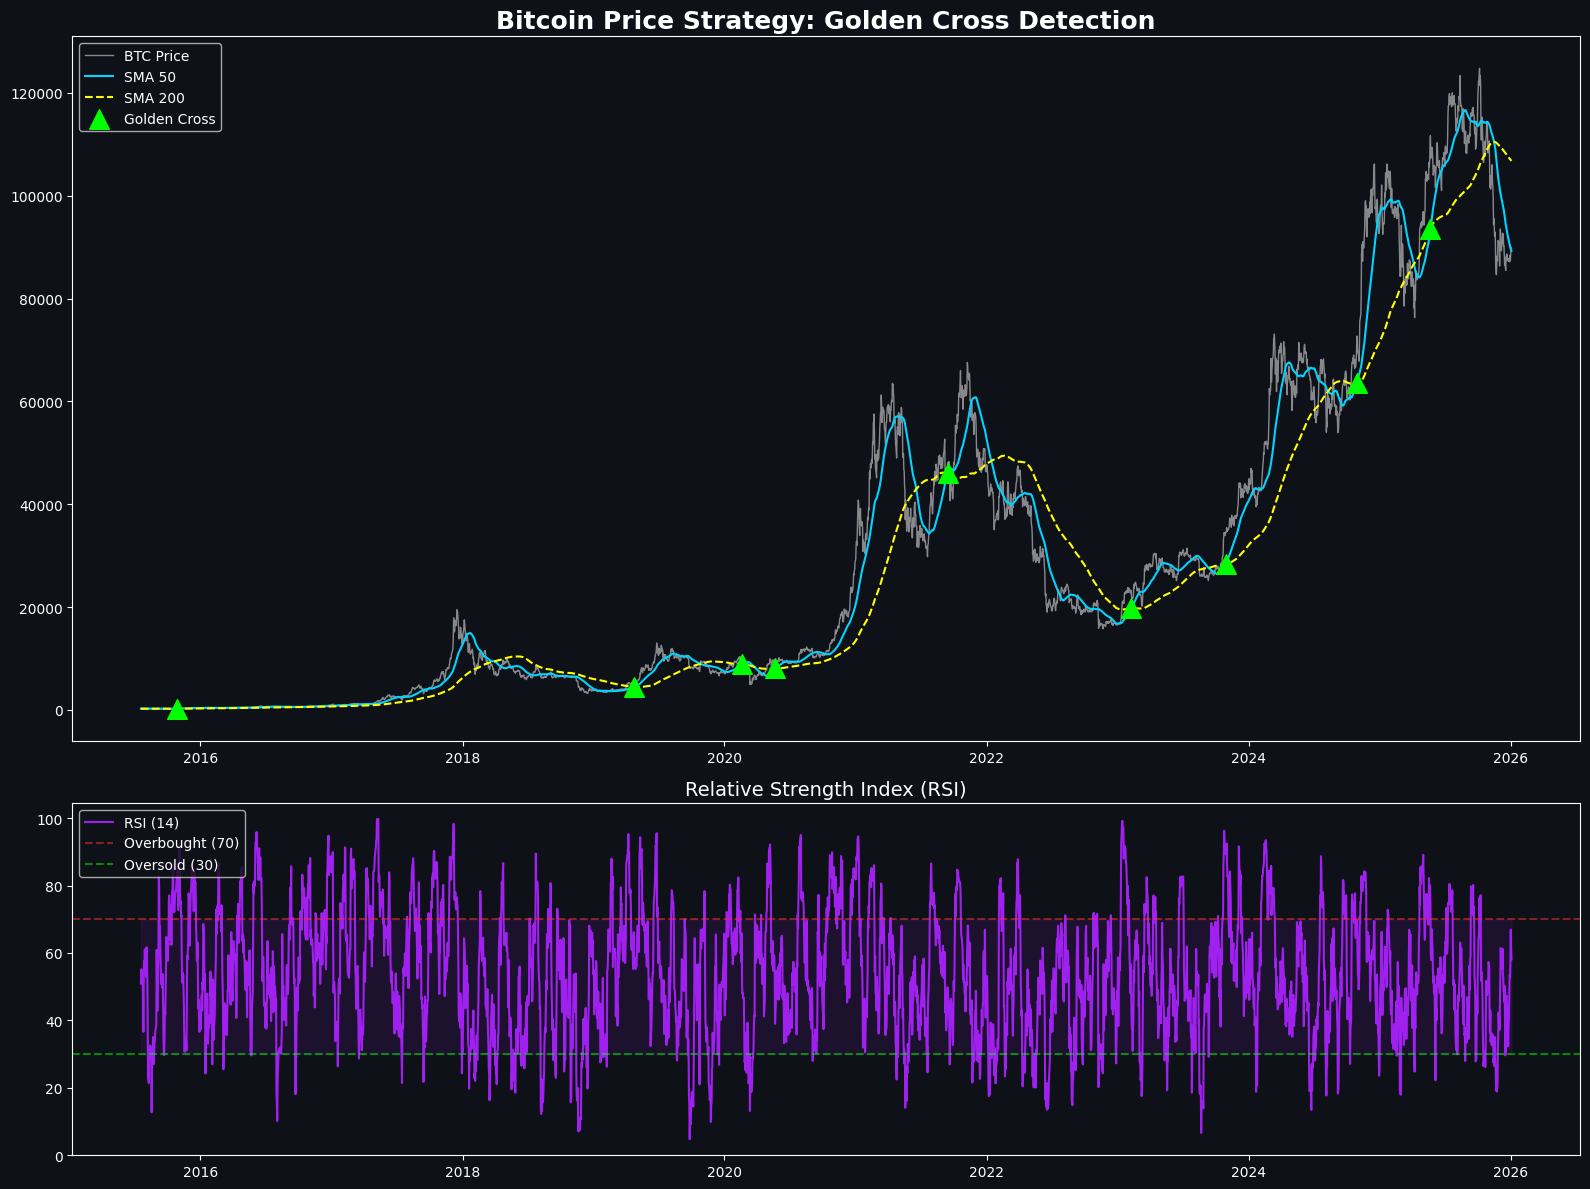

In [16]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 12), gridspec_kw={'height_ratios': [2, 1]})

# Plot 1: Price + Golden Cross
ax1.plot(df.index, df['Close'], label='BTC Price', color=colors['price'], alpha=0.5, linewidth=1)
ax1.plot(df.index, df['SMA_50'], label='SMA 50', color=colors['sma50'], linewidth=1.5)
ax1.plot(df.index, df['SMA_200'], label='SMA 200', color=colors['sma200'], linewidth=1.5, linestyle='--')

crosses = (df['SMA_50'] > df['SMA_200']) & (df['SMA_50'].shift(1) < df['SMA_200'].shift(1))
ax1.scatter(df.index[crosses], df['SMA_50'][crosses], marker='^', color=colors['bull'], s=200, label='Golden Cross', zorder=5)

ax1.set_title('Bitcoin Price Strategy: Golden Cross Detection', fontsize=18, fontweight='bold', color='white')
ax1.legend(loc='upper left')

# Plot 2: RSI Indicator
ax2.plot(df.index, df['RSI'], color='#A020F0', label='RSI (14)')
ax2.axhline(70, linestyle='--', color=colors['bear'], alpha=0.5, label='Overbought (70)')
ax2.axhline(30, linestyle='--', color=colors['bull'], alpha=0.5, label='Oversold (30)')
ax2.fill_between(df.index, 70, 30, color='#A020F0', alpha=0.1)
ax2.set_title('Relative Strength Index (RSI)', fontsize=14, color='white')
ax2.legend(loc='upper left')

plt.tight_layout()
plt.show()

# Feature Selection

In [17]:
df['Target'] = (df['Close'].shift(-1) > df['Close']).astype(int)

features = ['SMA_50', 'SMA_200', 'RSI', 'MACD', 'Volume', 'Daily_Return']
X = df[features]
y = df['Target']

# Data Split

In [18]:
# Train/Test Split
split_idx = int(len(df) * 0.8)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

# Fit model

In [19]:
model = RandomForestClassifier(n_estimators=100, min_samples_split=10, random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(min_samples_split=10, random_state=42)

# Evaluation


🤖 Algo-Trading Model Accuracy: 52.16%


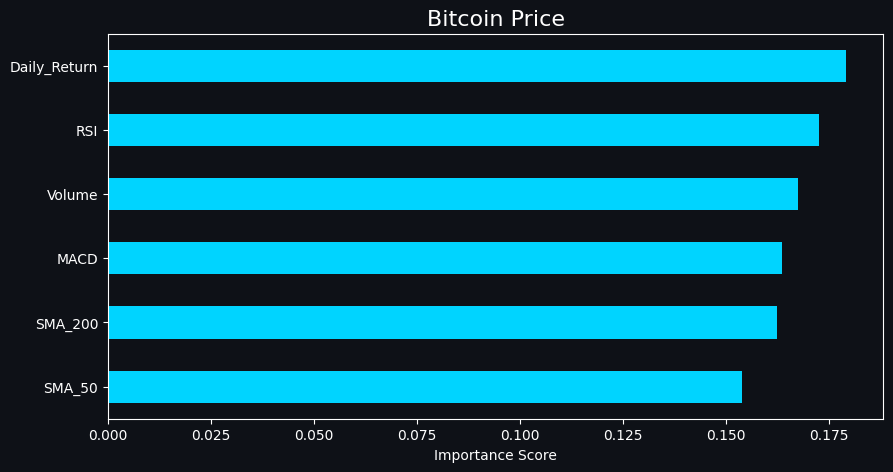


📝 INSIGHT: If RSI is the top feature, the market is driven by momentum.


In [20]:

accuracy = model.score(X_test, y_test)
print(f"\n🤖 Algo-Trading Model Accuracy: {accuracy*100:.2f}%")

# Feature Importance
imp = pd.Series(model.feature_importances_, index=features).sort_values()
plt.figure(figsize=(10, 5))
imp.plot(kind='barh', color=colors['sma50'])
plt.title("Bitcoin Price", fontsize=16)
plt.xlabel("Importance Score")
plt.show()

print("\n📝 INSIGHT: If RSI is the top feature, the market is driven by momentum.")

# Thanks!